In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input, Dropout,GRU
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from scipy.integrate import odeint 
from math import *
import time

2024-10-27 19:38:06.179393: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-27 19:38:06.188853: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-27 19:38:06.199916: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-27 19:38:06.203076: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-27 19:38:06.211234: I tensorflow/core/platform/cpu_feature_guar

In [2]:
#xy0 is [x0,y0] vxy0 is [vx0, vy0]
def projectile_motion(g, mu, xy0, vxy0, tt):
    # use a four-dimensional vector function vec = [x, y, vx, vy]
    def dif(vec, t):
        # time derivative of the whole vector vec
        v = sqrt(vec[2] ** 2 + vec[3] ** 2)
        return [vec[2], vec[3], -mu * v * vec[2], -g - mu * v * vec[3]]

    # solve the differential equation numerically
    vec = odeint(dif, [xy0[0], xy0[1], vxy0[0], vxy0[1]], tt)
    return vec[:, 0], vec[:, 1], vec[:, 2], vec[:, 3]  # return x, y, vx, vy

def makepath(angle, vel, t_final,d_t):
    alpha0 = radians(angle)
    xy = [0.0, 0.0]
    vxy =[vel * cos(alpha0), vel* sin(alpha0)]
    t = np.arange(0, t_final,  d_t)
    x, y, vx, vy = projectile_motion(g, mu, (xy[0], xy[1]), (vxy[0], vxy[1]), t)
    return x, y, vx, vy, t

# Parameters of projectile (modelled after a baseball)
g       = 9.81         # Acceleration due to gravity (m/s^2)
rho_air = 1.29         # Air density (kg/m^3)
v0      = 44.7         # Initial velocity (m/s)
m       = 0.145        # Mass of projectile (kg)
cD      = 0.5          # Drag coefficient (spherical projectile)
r       = 0.0366       # Radius of projectile (m)
mu = 0.5 * cD * (pi * r ** 2) * rho_air / m

In [3]:
train_window = 15

def create_inout_sequences_batches(input_data, tw):
    inout_seq = []
    batches,L,dim = (input_data).shape
    for i in range(batches):
        for j in range(L-tw):
            train_seq = input_data[i,j:j+tw,:]
            train_label = input_data[i,j+tw:j+tw+1,:]
            inout_seq.append((train_seq ,train_label))
    return inout_seq


In [4]:
np.random.seed(42)
solucoes = []
angulos = np.arange(10,80,5)
velocidades = np.arange(100,1500,50)
for angulo in angulos:
    for velocidade in velocidades:
        X, Y, VX, VY, T  = makepath(angulo, velocidade, 10.1, 0.1) 
        solucao = np.stack((X,Y, VX, VY),axis=1)
        solucoes.append(solucao)

solucoes = np.array(solucoes)


'''#Linear scaling  (x-x_min)/(x_max-m_min) (-1,1)
inputs_min = np.min(solucoes,axis=(0,1))
inputs_max = np.max(solucoes,axis=(0,1))
print(inputs_min)
print(inputs_max)
inputs_normalizados = (((solucoes-inputs_min)/(inputs_max-inputs_min))-0.5)*2'''

#Scalling manual Z score (x - x_mean)/(x_std)
inputs_mean = np.mean(solucoes,axis=(0,1))
inputs_std = np.std(solucoes,axis=(0,1))

print(inputs_mean)
print(inputs_std)

inputs_normalizados = (solucoes-inputs_mean)/(inputs_std)

solucoes2 = []
for i in range(7):
    angulo = np.random.uniform(15,25)
    velocidade = np.random.uniform(50,1700)
    X, Y, VX, VY, T = makepath(angulo, velocidade,10.1,0.1) 
    solucao = np.stack((X, Y, VX,VY),axis=1)
    solucoes2.append(solucao)

solucoes2 = []
for i in range(7):
    angulo = np.random.uniform(75,80)
    velocidade = np.random.uniform(50,1700)
    X, Y, VX, VY, T = makepath(angulo, velocidade,10.1,0.1) 
    solucao = np.stack((X, Y, VX,VY),axis=1)
    solucoes2.append(solucao)


solucoes2 = np.array(solucoes2)
#inputs_normalizados2 = (((solucoes2-inputs_min)/(inputs_max-inputs_min))-0.5)*2
inputs_normalizados2 = (solucoes2-inputs_mean)/(inputs_std)

sequencias = create_inout_sequences_batches(inputs_normalizados,train_window) 
sequencias_val = create_inout_sequences_batches(inputs_normalizados2,train_window) 
train_inputs = tf.convert_to_tensor([sequencias[i][0] for i in range(len(sequencias))],dtype=tf.float32)
train_outputs = tf.reshape(tf.convert_to_tensor([sequencias[i][1] for i in range(len(sequencias))],dtype=tf.float32),(-1,4))
val_inputs = tf.convert_to_tensor([sequencias_val[i][0] for i in range(len(sequencias_val))],dtype=tf.float32)
val_outputs = tf.reshape(tf.convert_to_tensor([sequencias_val[i][1] for i in range(len(sequencias_val))],dtype=tf.float32),(-1,4))

[240.07782282 137.4765154   33.62397232   8.25031217]
[114.07432635 112.17994482  76.32264249  77.8123405 ]


I0000 00:00:1730068690.018398  414846 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730068690.047709  414846 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730068690.048962  414846 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730068690.051202  414846 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [6]:
angulos, velocidades

(array([10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]),
 array([ 100,  150,  200,  250,  300,  350,  400,  450,  500,  550,  600,
         650,  700,  750,  800,  850,  900,  950, 1000, 1050, 1100, 1150,
        1200, 1250, 1300, 1350, 1400, 1450]))

In [5]:
solucoes.shape

(392, 101, 4)

In [104]:
model_keras = Sequential([
    Input((train_window,4)),
    LSTM(256, return_sequences=1),
    LSTM(128, return_sequences=0),
    (Dense(4))])
model_keras.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 15, 256)        │       267,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 464,900 (1.77 MB)

 Trainable params: 464,900 (1.77 MB)

 Non-trainable params: 0 (0.00 B)

In [112]:
early_stop = EarlyStopping(monitor="val_loss",patience=150,restore_best_weights=True)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=100,
    decay_rate=0.98)

def scaled_mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred) * 100)

def max_error_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))+2*tf.reduce_mean(tf.abs(y_true - y_pred))



model_keras.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001,amsgrad=1), loss="mse",metrics=["mae"])
history = model_keras.fit(train_inputs,train_outputs,validation_data=(val_inputs,val_outputs),epochs=5000,batch_size=256*4, verbose = 2,callbacks=early_stop,shuffle=1)
#model_keras.save("LSTM_bal_geral.keras")

Epoch 1/5000
72/72 - 1s - 20ms/step - loss: 1.3290e-07 - mae: 2.3750e-04 - val_loss: 5.2991e-07 - val_mae: 4.4176e-04
Epoch 2/5000
72/72 - 1s - 7ms/step - loss: 1.3327e-07 - mae: 2.3795e-04 - val_loss: 5.2605e-07 - val_mae: 4.4276e-04
Epoch 3/5000
72/72 - 0s - 6ms/step - loss: 1.3298e-07 - mae: 2.3737e-04 - val_loss: 5.6604e-07 - val_mae: 4.5877e-04
Epoch 4/5000
72/72 - 0s - 6ms/step - loss: 1.3331e-07 - mae: 2.3789e-04 - val_loss: 5.6470e-07 - val_mae: 4.5876e-04
Epoch 5/5000
72/72 - 0s - 6ms/step - loss: 1.3358e-07 - mae: 2.3856e-04 - val_loss: 5.4042e-07 - val_mae: 4.5105e-04
Epoch 6/5000
72/72 - 0s - 6ms/step - loss: 1.3335e-07 - mae: 2.3818e-04 - val_loss: 5.3039e-07 - val_mae: 4.4952e-04
Epoch 7/5000
72/72 - 0s - 6ms/step - loss: 1.3358e-07 - mae: 2.3856e-04 - val_loss: 5.3122e-07 - val_mae: 4.4988e-04
Epoch 8/5000
72/72 - 0s - 6ms/step - loss: 1.3296e-07 - mae: 2.3768e-04 - val_loss: 5.2111e-07 - val_mae: 4.4075e-04
Epoch 9/5000
72/72 - 0s - 6ms/step - loss: 1.3357e-07 - mae: 2.

KeyboardInterrupt: 

In [12]:
tf.keras.models.save_model(model_keras,"LSTM_bal_last_try.keras")

In [114]:
model_keras = tf.keras.models.load_model("LSTM_bal_last_try.keras")

tf.Tensor(0.16232647600385328, shape=(), dtype=float64)


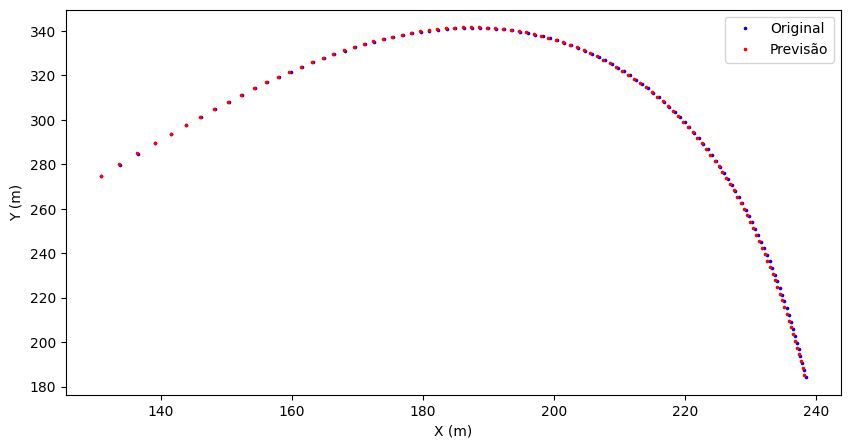

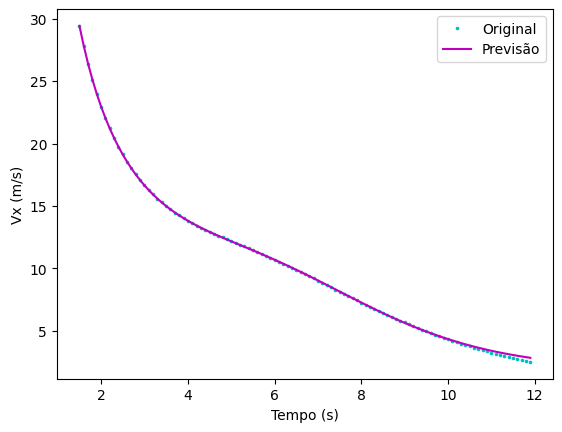

'\nplt.plot(t_pontos[m:n], v_y[m:n], \'co\', label="Original",markersize=1.6)\nplt.plot(t_pontos[m:n], vy_2[m:n], \'m-\', label="Previsão",markersize=0.4)\nplt.legend()\nplt.xlabel("Tempo (s)")\nplt.ylabel("Vy (m/s)")\nplt.show()'

In [119]:
t_final = 12

X, Y, VX, VY, T  = makepath(65, 1200.0, t_final+0.1, 0.1) 
sol2 = np.stack((X, Y, VX,VY),axis=1)
#previsoes = ((2*(sol2[:train_window,:]+0*np.random.normal(size=(train_window,4))-inputs_min)/(inputs_max-inputs_min)-0.5)).tolist()
#sol2 = 2*((sol2-inputs_min)/(inputs_max-inputs_min)-0.5)
#previsoes = ((sol2[:train_window,:]+0*np.random.normal(size=(train_window,4))-inputs_mean)/inputs_std).tolist()
sol2 = (sol2-inputs_mean)/inputs_std
previsoes = (sol2[:train_window,:]+0*(np.random.normal(0,0.005 * np.ptp(sol2,axis=0),size=(train_window,4)))).tolist()
for i in range(101-train_window+t_final*10-100):
    prev_temp = model_keras((np.array([previsoes[k][:] for k in range(i,train_window+i)]).reshape(-1,train_window,4)),training=False)
    previsoes.append(prev_temp.numpy().tolist()[0])
previsoes = np.array(previsoes)*inputs_std+inputs_mean
sol2 = sol2*inputs_std+inputs_mean

plt.figure(figsize=(10,5))
x = sol2[:,0]
y =  sol2[:,1]
v_x = sol2[:,2]
#v_y =  sol2[:,3]
x_2 = previsoes[:,0]
y_2 = previsoes[:,1]
vx_2 = previsoes[:,2]
#vy_2 = previsoes[:,3]
print((tf.reduce_mean(tf.abs(previsoes[train_window+0*(101-train_window):]-sol2[train_window+0*(101-train_window):]))))

n = -1
m = train_window

t_pontos = np.arange(0,t_final+0.1,0.1)
plt.plot(x[m:n], y[m:n], 'bo', label="Original",markersize=1.6)
plt.plot(x_2[m:n], y_2[m:n], 'ro', label="Previsão",markersize=1.6)
plt.legend()
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.show()

plt.plot(t_pontos[m:n], v_x[m:n], 'co', label="Original",markersize=1.6)
plt.plot(t_pontos[m:n], vx_2[m:n], 'm-', label="Previsão",markersize=0.4)
plt.legend()
plt.xlabel("Tempo (s)")
plt.ylabel("Vx (m/s)")
plt.show()
'''
plt.plot(t_pontos[m:n], v_y[m:n], 'co', label="Original",markersize=1.6)
plt.plot(t_pontos[m:n], vy_2[m:n], 'm-', label="Previsão",markersize=0.4)
plt.legend()
plt.xlabel("Tempo (s)")
plt.ylabel("Vy (m/s)")
plt.show()'''

In [42]:
mae = np.zeros(4)
mae2 = np.ones(1)
mae = np.append(mae,mae2)
print(mae)

[0. 0. 0. 0. 1.]


In [43]:
def teste(angulos, velocidades, extrapol, ruido):
    mse = 0
    mae = 0
    mae2 = 0
    cont = 0

    mae_min = 999
    mae_max = 0
    combinacao_min = 0
    combinacao_max = 0

    for angle in angulos:
        for velocity in velocidades:
            t_final = 10 + 2*extrapol
            sol2 = np.stack(makepath(angle,velocity,t_final+0.1,0.1)[:4],axis=1)
            previsoes = ((sol2[:train_window,:]+ruido*np.random.normal(0,0.005 * np.ptp(sol2,axis=0),size=(train_window,4))-inputs_mean)/inputs_std).tolist()
            for i in range(101-train_window+t_final*10-100):
                prev_temp = model_keras((np.array([previsoes[k][:] for k in range(i,train_window+i)]).reshape(-1,train_window,4)))
                previsoes.append(prev_temp.numpy().tolist()[0])
            previsoes = np.array(previsoes)*inputs_std+inputs_mean
            mse_temp0=(tf.reduce_mean(tf.square(previsoes[train_window+extrapol*(101-train_window):]-sol2[train_window+extrapol*(101-train_window):]),axis=0))
            mae_temp0=(tf.reduce_mean(tf.abs(previsoes[train_window+extrapol*(101-train_window):]-sol2[train_window+extrapol*(101-train_window):]),axis=0))
            mae_temp1=(tf.reduce_mean(tf.abs(previsoes[train_window+extrapol*(101-train_window):]-sol2[train_window+extrapol*(101-train_window):])))
            mse+=mse_temp0
            mae+=mae_temp0
            mae2+=mae_temp1
            cont+=1

            if mae_temp1<=mae_min:
                mae_min = mae_temp1
                combinacao_min = [angle,velocity]
            if mae_temp1>=mae_max:
                mae_max= mae_temp1
                combinacao_max = [angle,velocity]
    
    #tf.print(f"MSE {mse/cont}")
    mae = np.append(mae,mae2)
    with np.printoptions(precision=3):
        tf.print(f"MAE {mae/cont}")
            
    #print(combinacao_max, mae_max)
    #print(combinacao_min,mae_min)
    print()
    

In [48]:
angulos1 = np.linspace(15,20,5)
angulos2 = np.linspace(20.5,75,15)
angulos3 =  np.linspace(75.5,80,5)
velocidades1 = np.linspace(50,1500,15)
velocidades2 = np.linspace(1500,1800,15)


lista_angulos = [angulos1,angulos2,angulos3]
lista_velocidades = [velocidades1,velocidades2]

'''print("Sem Nada")
print()
cont_velocidade = 1
cont_angulo = 1
for velocidades in lista_velocidades:
    cont_angulo = 1
    for angulos in lista_angulos:
        print(f"V{cont_velocidade} A{cont_angulo}")
        teste(angulos,velocidades,extrapol=False,ruido=False)
        cont_angulo +=1
    cont_velocidade+=1'''
print("Extrapolação")
print()
cont_velocidade = 1
cont_angulo = 1
for velocidades in lista_velocidades:
    cont_angulo = 1
    for angulos in lista_angulos:
        print(f"V{cont_velocidade} A{cont_angulo}")
        teste(angulos,velocidades,extrapol=True,ruido=False)
        cont_angulo +=1
    cont_velocidade+=1
print("Ruído")
print()
'''
cont_velocidade = 1
cont_angulo = 1
for velocidades in lista_velocidades:
    cont_angulo = 1
    for angulos in lista_angulos:
        print(f"V{cont_velocidade} A{cont_angulo}")
        teste(angulos,velocidades,extrapol=False,ruido=True)
        cont_angulo +=1
    cont_velocidade+=1'''


Extrapolação

V1 A1
MAE [0.816 0.997 0.123 0.098 0.508]

V1 A2
MAE [0.79  0.917 0.156 0.202 0.517]

V1 A3
MAE [1.839 1.588 0.091 0.328 0.962]

V2 A1
MAE [1.231 0.193 0.177 0.023 0.406]

V2 A2
MAE [0.91  0.851 0.234 0.203 0.549]

V2 A3
MAE [2.339 2.396 0.068 0.512 1.329]

Ruído



'\ncont_velocidade = 1\ncont_angulo = 1\nfor velocidades in lista_velocidades:\n    cont_angulo = 1\n    for angulos in lista_angulos:\n        print(f"V{cont_velocidade} A{cont_angulo}")\n        teste(angulos,velocidades,extrapol=False,ruido=True)\n        cont_angulo +=1\n    cont_velocidade+=1'

In [41]:
print(tf.reduce_mean(np.array([0.18889493 ,0.25503326 ,0.04880924 ,0.04733447])))
print(tf.reduce_mean(np.array([0.21001024 ,0.2284679 ,0.04089467 ,0.05304275])))

tf.Tensor(0.13501797499999998, shape=(), dtype=float64)
tf.Tensor(0.13310389, shape=(), dtype=float64)


In [147]:
angulos1 = np.linspace(5,25,8)
angulos2 = np.linspace(25,70,8)
angulos3 =  np.linspace(70,85,8)
velocidades1 = np.linspace(50,500,12)
velocidades2 = np.linspace(520,1200,12)
angulos_teste = [angulos1,angulos2]
velocidades_teste = [velocidades1, velocidades2]
mse = 0
mae = 0
cont = 0

mae_min = 999
mae_max = 0
combinacao_min = 0
combinacao_max = 0


for angle in angulos2:
    for velocity in velocidades2:
        t_final = 10
        sol2 = np.stack(makepath(angle,velocity,t_final+0.1,0.1)[:4],axis=1)
        previsoes = ((sol2[:train_window,:]+np.random.normal(0,0.005 * np.ptp(sol2,axis=0),size=(train_window,4))-inputs_mean)/inputs_std).tolist()
        #sol2 = (sol2-inputs_mean)/inputs_std
        for i in range(101-train_window+t_final*10-100):
            prev_temp = model_keras((np.array([previsoes[k][:] for k in range(i,train_window+i)]).reshape(-1,train_window,4)))
            previsoes.append(prev_temp.numpy().tolist()[0])
        previsoes = np.array(previsoes)*inputs_std+inputs_mean
        mse_temp0=(tf.reduce_mean(tf.square(previsoes[train_window:]-sol2[train_window:]),axis=0))
        mae_temp0=(tf.reduce_mean(tf.abs(previsoes[train_window:]-sol2[train_window:]),axis=0))
        mae_temp1=(tf.reduce_mean(tf.abs(previsoes[train_window:]-sol2[train_window:])))
        mse+=mse_temp0
        mae+=mae_temp0
        cont+=1

        if mae_temp1<=mae_min:
            mae_min = mae_temp1
            combinacao_min = [angle,velocity]
        if mae_temp1>=mae_max:
            mae_max= mae_temp1
            combinacao_max = [angle,velocity]
        t_pontos = np.arange(0,t_final+0.1,0.1)
        plotar = np.random.randint(0,11)
        if plotar<=-2:
            plt.figure(figsize=(10,5))
            x = sol2[:,0]
            y =  sol2[:,1]
            v_x = sol2[:,2]
            #v_y =  sol2[:,3]
            x_2 = previsoes[:,0]
            y_2 = previsoes[:,1]
            vx_2 = previsoes[:,2]
            #vy_2 = previsoes[:,3]
            n = -1
            m = 0
            print(angle,velocity)
            plt.plot(x[m:n], y[m:n], 'b-', label="Original")
            plt.plot(x_2[m:n], y_2[m:n], 'ro', label="Previsão",markersize=1.6)
            plt.legend()
            plt.xlabel("X (m)")
            plt.ylabel("Y (m)")
            plt.show()

            plt.plot(t_pontos[m:n], v_x[m:n], 'co', label="Original",markersize=1.6)
            plt.plot(t_pontos[m:n], vx_2[m:n], 'm-', label="Previsão",markersize=0.4)
            plt.legend()
            plt.xlabel("Tempo (s)")
            plt.ylabel("Vx (m/s)")
            plt.show()

            ''' plt.plot(t_pontos[m:n], v_y[m:n], 'co', label="Original",markersize=1.6)
            plt.plot(t_pontos[m:n], vy_2[m:n], 'm-', label="Previsão",markersize=0.4)
            plt.legend()
            plt.xlabel("Tempo (s)")
            plt.ylabel("Vy (m/s)")
            plt.show()'''
tf.print(f"MSE {mse/cont}")
tf.print(f"MAE {mae/cont}")
        
print(combinacao_max, mae_max)
print(combinacao_min,mae_min)




MSE [1.02490458 3.38440503 0.0490556  0.11977927]
MAE [0.77778954 1.40420125 0.19421779 0.28149392]
[50.714285714285715, 1200.0] tf.Tensor(1.8698038161733017, shape=(), dtype=float64)
[70.0, 520.0] tf.Tensor(0.21869707046528675, shape=(), dtype=float64)


A1 V1

MSE [0.29328618 0.51400317 0.04029499 0.05512657]
MAE [0.47634371 0.38978064 0.1843329  0.23003552]

A1 V2

MSE [0.66079352 0.18486879 0.04997251 0.07038287]
MAE [0.61776186 0.3519006  0.21615177 0.25681546]

A2 V1

MSE [0.47415579 0.87002143 0.04029732 0.06579238]
MAE [0.54224313 0.73533236 0.18528447 0.23735597]

A2 V2

MSE [0.34939756 0.46595744 0.04262309 0.0710746 ]
MAE [0.46316192 0.58118566 0.1938182  0.26044006]


A3 V1

MSE [0.69344004 0.7804399  0.03257635 0.09367686]
MAE [0.34910958 0.76170286 0.15092855 0.28647951]

A3 V2

MSE [0.21458727 0.91505053 0.02471075 0.09939664]
MAE [0.29720921 0.80212347 0.14788017 0.30884292]

Ruído 

A1 V1

MSE [0.7150383  0.72000248 0.03959585 0.05871374]
MAE [0.69654436 0.52413562 0.17795677 0.23253664]


A1 V2

MSE [1.66486462 1.1958982  0.06105694 0.08961896]
MAE [1.00167786 0.77407748 0.22212461 0.27479312]

A2 V1

MSE [0.5171753  1.018246   0.04115828 0.07048265]
MAE [0.54554058 0.79622875 0.1860715  0.24332374]

A2 V2

MSE [1.02490458 3.38440503 0.0490556  0.11977927]
MAE [0.77778954 1.40420125 0.19421779 0.28149392]


A3 V1

MSE [0.71745728 1.0830317  0.03252979 0.11037695]
MAE [0.39304827 0.84827356 0.14945838 0.30139475]

A3 V2

MSE [0.38012348 3.43624309 0.02681509 0.16856152]
MAE [0.45864211 1.39750707 0.1491021  0.35522227]

Extrapolação

A1 V1

MSE [2.34190622e+00 1.49270469e+01 5.04577502e-03 7.02118645e-02]
MAE [0.97029527 1.62271149 0.05768285 0.26113022]

A1 V2

MSE [5.94898204e+00 4.36342731e+00 5.62829864e-03 5.66144513e-02]
MAE [1.77715743 1.18175539 0.06295786 0.22591814]

A2 V1 

MSE [0.74441147 2.04438025 0.01701697 0.03216779]
MAE [0.5403056  0.80540677 0.10485802 0.16232653]

A2 V2

MSE [0.9240712  0.7639655  0.02438459 0.03213341]
MAE [0.77871687 0.7411332  0.11961183 0.15832839]

A3 V1

MSE [8.19929973 4.3917567  0.04926804 0.06077294]
MAE [1.05595061 1.07006132 0.15888419 0.21837134]

A3 V2

MSE [0.37416266 1.56467991 0.01459829 0.01703789]
MAE [0.42242593 1.00991543 0.09453246 0.10865201]